# Rondas 1 y 2



### 1. Medida de Riesgo
* definir variables target
* preprocesar variables 
* calcular indice de riesgo
* definir etiquetas

### 2. Modelo
* gridsearch
* entrenar regresion
* ROC
* Matriz de Confusion
* Reporte de clasificacion
* Otros analisis (variables y quintiles)


In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
import statsmodels.api as sm
import time

#%pylab inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#formato de visualizaciones


In [2]:
def risk_calculation(pond, df_with_dummies, ronda, var_socioec, var_salud, var_antrp):
    if pond == 'standar':
        var_target = var_socioec + var_salud + var_antrp

        pond_socioec  = 1/len(var_socioec)
        pond_salud = 1/len(var_salud)
        pond_antrp = 1/len(var_antrp)

        data_ronda = df_with_dummies[df_with_dummies.ronda == ronda].sort_values(by = 'childid')

        min_max_scaler = MinMaxScaler() 
        data_ronda.loc[:,var_target] = min_max_scaler.fit_transform(data_ronda.loc[:,var_target])

        score_salud = (data_ronda.loc[:,var_salud] * pond_salud).sum(axis=1)
        score_antrp = (data_ronda.loc[:,var_antrp] * pond_antrp).sum(axis=1)
        score_socioec = (data_ronda.loc[:,var_socioec] * pond_socioec).sum(axis=1)
        
        score_final = (1/3) * score_salud + (1/3) * score_antrp + (1/3) * score_socioec 

        data_ronda["risk"] = score_final
        data_ronda["risk"] = np.where(data_ronda.deceased == 1, 1, data_ronda.risk)
    else:
        print("need to adjust manually")
    
    return data_ronda;


def label_observation(y_prob, prop, classes = None):
    if classes == 'binary':
        cut = round((1-prop)/0.1)
        y_pred = pd.DataFrame(y_prob, columns = ['y_test_prob'])
        y_pred = pd.qcut(y_pred.y_test_prob, 10, labels = False, duplicates = 'drop')
        y_pred = np.where(y_pred >= cut,1,0)
    else:
        print('modify function')
    return y_pred;

        

## Carga de dataset

In [3]:
# importo los datos
df = pd.read_csv("Desktop/TESIS/df_final.csv", na_values=' ')
df.rename(columns={'round': 'ronda'}, inplace=True)
df.head()

,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,maths_raw,ppvt_raw,rawscre,reading_raw,sppvt_raw,srawscre,score_cog,rscorelang_cog,rscorelang_ppvt,score_ppvt
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,NaN,NaN,22.000,NaN,NaN,NaN,9.000,305.212,280.317,22.000
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,21.000,80.000,80.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modificaciones y transformaciones de variables antes de dividir por ronda

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# modifico las variables para el target para que a mayor valor, mayor riesgo
# CATEGORICAS

df.chsex = np.where(df.chsex == 2,0,1) 

df.headsex = np.where(df.headsex == 2,0,1) 

df.caresex = np.where(df.caresex == 2,0,1) 

df['chhrel_mod'] = np.where(df.chhrel == 3,1,0)  # marco solo el caso "Worse", no el de "Same" o "Better"



df['bmi_cat'] = 0
df.loc[df.bmi < 18.5 , "bmi_cat"] = 2
df.loc[(df.bmi >= 18.5) & (df.bmi <22), "bmi_cat"] = 0
df.loc[(df.bmi >= 22) & (df.bmi <24.9) , "bmi_cat"] = 1
df.loc[(df.bmi >= 24.9) & (df.bmi <29.9) , "bmi_cat"] = 2
df.loc[(df.bmi >=29.9) , "bmi_cat"] = 3

#pd.cut(x=df['bmi'], bins=[0, 18.5, 22, 24.9, 29.9, 500 ],ordered=False,
#                     labels=[2, 0, 1, 2, 3])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# modifico las variables para el target para que a mayor valor, mayor riesgo
# CONTINUAS

df["wi"] = ((df["wi"] - 1) * -1)
df["hq"] = ((df["hq"] - 1) * -1)
df["cd"] = ((df["cd"] - 1) * -1)
df["sv"] = ((df["sv"] - 1) * -1)

df.loc[df["wi"].isna(),'wi'] = 1
df.loc[df["hq"].isna(),'hq'] = 1
df.loc[df["cd"].isna(),'cd'] = 1
df.loc[df["sv"].isna(),'sv'] = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Quito variables y hago arreglos finales en todo el dataset

# Paso a dummy variables PREDICTORAS que son NO ordinales.
dummie_list = ["headrel","carerel","carehead","entype","chrephealth4",'chdisscale',"region"]
dummies = pd.concat([pd.get_dummies(df[col]) for col in dummie_list], axis=1, keys=dummie_list)
df_with_dummies = pd.concat([df,dummies],axis = 1)

# paso a int la unica variable que quedó en formato "objeto"
df.hospital.replace(['Yes', 'No'],[0,1], inplace=True)

## Definicion de variables para cada ronda
Se mantienen separadas por si en algun futuro alguna ronda es modificada independientemente de las demas

In [5]:

# Para cada eje (salud, socioeconomico, etc)
# definimos las variables que determinan si el niño estuvo expuesto a una situacion de riesgo o no
# la idea es hacerlo para cada ronda

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 1

var_r1_socioec_cat = []
var_r1_socioec_cont  = ['wi',"hq","cd","sv"]
var_r1_socioec = var_r1_socioec_cont + var_r1_socioec_cat

var_r1_salud_cat = ["chhrel","chmightdie","deceased"]
var_r1_salud_cont = []
var_r1_salud = var_r1_salud_cat + var_r1_salud_cont

var_r1_familia_cat = []
var_r1_familia_cont = []
var_r1_familia = var_r1_familia_cat + var_r1_familia_cont

var_r1_antrp_cat = ['stunting',"bmi_cat"]
var_r1_antrp_cont = []
var_r1_antrp = var_r1_antrp_cat + var_r1_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 2

var_r2_socioec_cat = []
var_r2_socioec_cont  = ['wi',"hq","cd","sv"]
var_r2_socioec = var_r2_socioec_cont + var_r2_socioec_cat

var_r2_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r2_salud_cont = []
var_r2_salud = var_r2_salud_cat + var_r2_salud_cont

var_r2_familia_cat = []
var_r2_familia_cont = []
var_r2_familia = var_r2_familia_cat + var_r2_familia_cont

var_r2_antrp_cat = ['stunting',"bmi_cat"]
var_r2_antrp_cont = []
var_r2_antrp = var_r2_antrp_cat + var_r2_antrp_cont


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 3

var_r3_socioec_cat = []
var_r3_socioec_cont  = ['wi',"hq","cd","sv"]
var_r3_socioec = var_r3_socioec_cont + var_r3_socioec_cat
var_r3_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r3_salud_cont = []
var_r3_salud = var_r3_salud_cat + var_r3_salud_cont
var_r3_familia_cat = []
var_r3_familia_cont = []
var_r3_familia = var_r3_familia_cat + var_r3_familia_cont
var_r3_antrp_cat = ['stunting',"bmi_cat"]
var_r3_antrp_cont = []
var_r3_antrp = var_r3_antrp_cat + var_r3_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 4

var_r4_socioec_cat = []
var_r4_socioec_cont  = ['wi',"hq","cd","sv"]
var_r4_socioec = var_r4_socioec_cont + var_r4_socioec_cat
var_r4_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r4_salud_cont = []
var_r4_salud = var_r4_salud_cat + var_r4_salud_cont
var_r4_familia_cat = []
var_r4_familia_cont = []
var_r4_familia = var_r4_familia_cat + var_r4_familia_cont
var_r4_antrp_cat = ['stunting',"bmi_cat"]
var_r4_antrp_cont = []
var_r4_antrp = var_r4_antrp_cat + var_r4_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 5

var_r5_socioec_cat = []
var_r5_socioec_cont  = ['wi',"hq","cd","sv"]
var_r5_socioec = var_r5_socioec_cont + var_r5_socioec_cat
var_r5_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r5_salud_cont = []
var_r5_salud = var_r5_salud_cat + var_r5_salud_cont
var_r5_familia_cat = []
var_r5_familia_cont = []
var_r5_familia = var_r5_familia_cat + var_r5_familia_cont
var_r5_antrp_cat = ['stunting',"bmi_cat"]
var_r5_antrp_cont = []
var_r5_antrp = var_r5_antrp_cat + var_r5_antrp_cont

df.loc[:, df.dtypes == object].head()


,childid,dint,placeid
0,PE011001,9/2/2002,PE01C01
1,PE011001,3/26/2007,PE01C01
2,PE011001,8/10/2009,PE01C01
3,PE011001,8/8/2013,PE01C01
4,PE011001,8/11/2016,PE01C01


## Calculo el Riesgo por Round

In [6]:
r1 = risk_calculation('standar', df_with_dummies, 1, var_r1_socioec, var_r1_salud, var_r1_antrp)
r2 = risk_calculation('standar', df_with_dummies, 2, var_r2_socioec, var_r2_salud, var_r2_antrp)
r3 = risk_calculation('standar', df_with_dummies, 3, var_r3_socioec, var_r3_salud, var_r3_antrp)
r4 = risk_calculation('standar', df_with_dummies, 4, var_r4_socioec, var_r4_salud, var_r4_antrp)
r5 = risk_calculation('standar', df_with_dummies, 5, var_r5_socioec, var_r5_salud, var_r5_antrp)

/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanm

### Divido el riesgo en deciles

In [7]:
r1["risk_cat_1"] = pd.qcut(r1["risk"] , 10,labels = False)
r2["risk_cat_2"] = pd.qcut(r2["risk"] , 10,labels = False)
r3["risk_cat_3"] = pd.qcut(r3["risk"] , 10,labels = False)
r4["risk_cat_4"] = pd.qcut(r4["risk"] , 10,labels = False)
r5["risk_cat_5"] = pd.qcut(r5["risk"] , 10,labels = False)

### Visualizo la distribucion del indice de riesgo por ronda

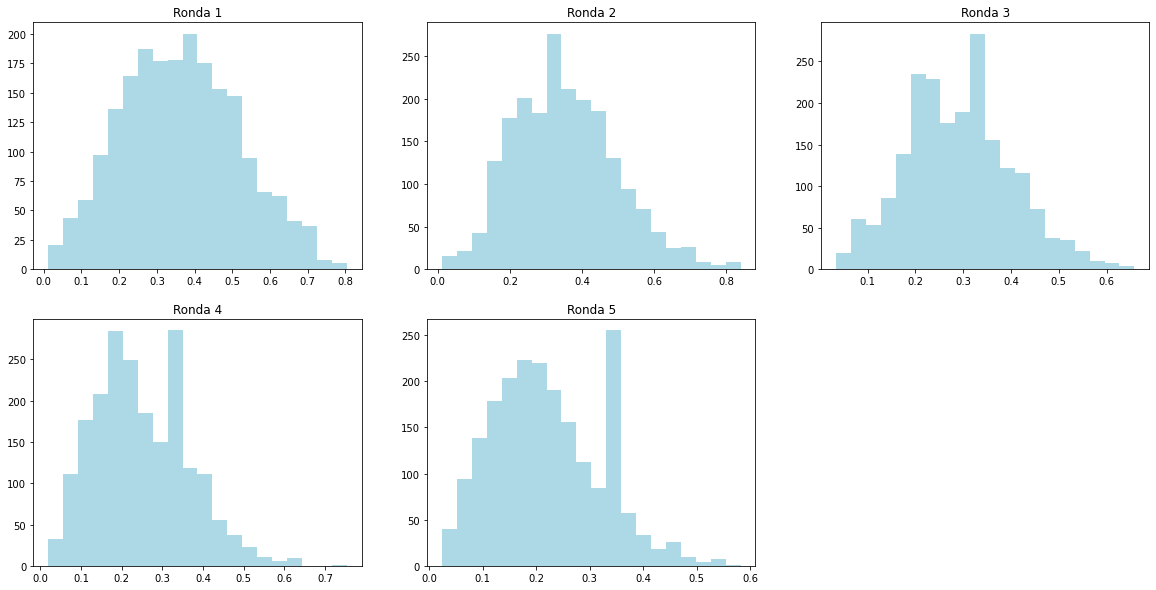

In [8]:
#pltrcParamsupdate({fontsize: 15})

#pltrcParamsupdate({fontsize: 15})
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(r1.risk, bins=20, color='lightblue')
plt.title("Ronda 1")

plt.subplot(2, 3, 2)
plt.hist(r2.risk, bins=20, color='lightblue')
plt.title("Ronda 2")

plt.subplot(2, 3, 3)
plt.hist(r3.risk, bins=20, color='lightblue')
plt.title("Ronda 3")

plt.subplot(2, 3, 4)
plt.hist(r4.risk, bins=20, color='lightblue')
plt.title("Ronda 4")

plt.subplot(2, 3, 5)
plt.hist(r5.risk, bins=20, color='lightblue')
plt.title("Ronda 5")

plt.show()

## Armo el dataset para el entrenamiento
* saco columnas que repiten informacion del target
* separo en X e Y
* estandarizo variables
* relleno los NaN

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Quito variables "administrativas" y variables que repiten información del target
# Por ejemplo índice de masa corporal y el flag the unserweight.

admin = [ 'clustid','childid',"ronda","yc","panel12345","dint","agemon",'careid','dadid','headid','momid']

repeated_info = ["underweight" , "thinness", "drwaterq" , "toiletq" , "elecq" , "cookingq","bmi",
                "zwfa","zhfa","zbfa","zwfl","fwfl","fhfa","fwfa","fbfa","momyrdied","dadyrdied",'hospital','chweight']

dependet = ["risk","risk_cat_1","risk_cat_2",'risk_cat_3',"risk_cat_4",'risk_cat_5']
other = ['placeid']


print(len(admin),
      len(repeated_info),
      len(dependet),
      len(other))



#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#"levlread", "levlwrit","engrade" , "enrol" refuse to answer. REVISAR.!!!!!!!!!!

cols_to_keep = ["inround",
    'agegr1','aniany','anibeeh','anicowm','anicowt','anidonk','anidrau',
    'anifish','anifshr','anigoat','aniguin','anillam','animilk','aniothr',
    'anioxen','anipigs','anipoul','anirabb','anirumi','anishee','anishri',
    'anisnai','anispec','bcg','beca_yl','birth','birth_age','bonograt','bwdoc',
    'bwght','careage','carecantread','caredu','careladder','caresex','chalcohol',
    'chdisability','chhealth','chhprob','childloc','chillness',
    'chinjury',"chsmoke",'chsex','cladder','commsch','commwork','credit',
    "chrephealth3","chrephealth2","chrephealth1","careldr4yrs",
    'dadcantread','dadedu','dadlive',"dadage",'delivery','dpt',
    "engrade","enrol",
    'female05','female1317','female1860','female61','female612','foodsec',
    'hcare','hchore','headage','headedudu','headsex','hhsize','hib',
    'hplay','hschool','hsleep','hstudy','htask','hwork',
    'insur_yl','juntos',
    'lang_raw',"literate","levlread","levlwrit",
    'male05','male1317','male1860','male61','male612',"marrcohab",'marrcohab_age','maths_raw','measles','minsa_yl',
    'momage','momcantread','momedu','momlive','numante','ownhouse','ownlandhse',
    'polio','ppvt_raw','preprim','projoven_yl',
    'rawscre','reading_raw','rscorelang_cog','rscorelang_ppvt','score_cog',
    'score_ppvt','shcrime1','shcrime2','shcrime3','shcrime4','shcrime5','shcrime6','shcrime8',
    'shecon1','shecon10','shecon11','shecon12','shecon14','shecon2','shecon3','shecon4','shecon5',
    'shecon6','shecon7','shecon8','shecon9','shenv1','shenv10','shenv11','shenv12','shenv2','shenv3',
    'shenv4','shenv5','shenv6','shenv7','shenv8','shenv9','shfam1','shfam10','shfam12','shfam13',
    'shfam14','shfam15','shfam16','shfam17','shfam18','shfam2','shfam3','shfam4','shfam5','shfam6',
    'shfam7','shfam8','shfam9','shhouse1','shhouse2','shhouse3','shother','shregul1','shregul2',
    'shregul4','shregul5','shregul6','sisgrat_yl','sppvt_raw','srawscre',
    'tetanus','typesite',"timesch",
    ( 'headrel',  1.0),( 'headrel',  2.0),( 'headrel',  3.0),( 'headrel',  4.0),( 'headrel',  5.0),
    ( 'headrel',  6.0),( 'headrel',  7.0),( 'carerel',  1.0),( 'carerel',  2.0),( 'carerel',  3.0),
    ( 'carerel',  4.0),( 'carerel',  5.0),( 'carerel',  6.0),( 'carerel',  7.0),('carehead',  1.0),
    ('carehead',  2.0),('carehead',  3.0),(  'entype',  1.0),(  'entype',  2.0),(  'entype',  3.0),
    (  'entype',  4.0),(  'region', 31.0),(  'region', 32.0),(  'region', 33.0),(  'region', 88.0),
               ]


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# separo dataset de predictoras de la variable dependiente

X_r1 = r1.loc[:,cols_to_keep]
#x_train = x_train.loc[:,~(x_train.isnull().values.all(axis=0))] eliminar todas las columnas con null values
y_r1 = r1.risk_cat_1


X_r2 = r2.loc[:,cols_to_keep]
y_r2 = r2.risk_cat_2

X_r3 = r3.loc[:,cols_to_keep]
y_r3 = r3.risk_cat_3

X_r4 = r4.loc[:,cols_to_keep]
y_r4 = r4.risk_cat_4

X_r5 = r5.loc[:,cols_to_keep]
y_r5 = r5.risk_cat_5


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Reemplazo los nulos por cero.  REVISAR.!!!!!!!!!!

X_r1 = X_r1.fillna(0)
X_r2 = X_r2.fillna(0)
X_r3 = X_r3.fillna(0)
X_r4 = X_r4.fillna(0)
X_r5 = X_r5.fillna(0)




11 19 6 1


/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [10]:

print('cols_to_keep',len(cols_to_keep),'\n')
#print('still_need_work_to_include',len(still_need_to_work_on),'\n')


cols_to_keep 202 



# Training


In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_r1, y_r2, test_size=0.33, random_state=42)

In [13]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Estandarizo dataset de entrenamiento y test por separado

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

### Leave One Out

In [14]:
def train_and_evaluate_logit(X_train_scaled, y_train, X_test_scaled, y_test ,cut, reg,cv, splits = None):
    
    
    d = {}
    performance = [] 
    it = 0
    
    # for each lambda
    for j in reg:
        start = time.time()
        #print('reg',j)
        model = LogisticRegression(solver = "liblinear", 
                                 penalty = 'l1', 
                                 max_iter = 300,
                                 C = j
                                  )
       # final['reg'] = j
        # for each possible cut
        for i in cut:
            decile  = round((1-i)/0.1)
            y_train2 = np.where((y_train >= decile),1,0)
            y_test2 = np.where((y_test >= decile),1,0)
            #print('cut',i)
            
            # if training with LOO method
            if cv == 'loo':
                scores = []
                loo = LeaveOneOut()
                for train_index , test_index in loo.split(X_train_scaled):
                    X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
                    model.fit(X_sub_train,y_sub_train)
                    y_sub_test_proba = model.predict_proba(X_sub_test)[:,1:] 
                    y_sub_test_pred = np.where(y_sub_test_proba > 0.5,1,0)
                    score = np.where(y_sub_test_pred == y_sub_test,1,0)
                    scores.append(score)
                mean_score = float(sum(scores)/len(scores))
                #a[str(i)] = mean_score
                
                # evaluation
                model.fit(X_train_scaled,y_train2)
                test_predictions = model.predict_proba(X_test_scaled)[:,1:]
                train_predictions = model.predict_proba(X_train_scaled)[:,1:]
                
                fpr_log,tpr_log,thr_log = roc_curve(y_test2, test_predictions)
                test_auc = auc(fpr_log, tpr_log)
                fpr_log,tpr_log,thr_log = roc_curve(y_train2, train_predictions)
                train_auc = auc(fpr_log, tpr_log)
            
                #print(j,i,mean_score)
                data = dict(regularization = j,
                                         proportion_class = i, 
                                         mean_score = mean_score,
                                         test_auc =test_auc,
                                         train_auc=train_auc,
                           #              index=[it]
                           )
                #print(data)
                
                performance.append(data)
                #print("regularization:", j, "class balance:", i, "iteration:", it)
                it += 1
   
            # if training with Kfold method
'''            elif cv == 'kf':
                
                auc_score_test = []
                auc_score_train = []
                d = {}
                for train_index , test_index in kf.split(X_train_scaled):
                    X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
                    model.fit(X_sub_train,y_sub_train)
                    y_sub_test_proba = model.predict_proba(X_sub_test)[:,1:]
                    fpr_log, tpr_log, thr_log = roc_curve(y_sub_test, y_sub_test_proba)
                    test_auc = auc(fpr_log, tpr_log)
                    y_sub_train_proba = model.predict_proba(X_sub_train)[:,1:]
                    fpr_log, tpr_log, thr_log = roc_curve(y_sub_train, y_sub_train_proba)
                    train_auc = auc(fpr_log, tpr_log)
                    auc_score_test.append(test_auc)
                    auc_score_train.append(train_auc)
                    print("regularization:", j, "class balance:", i, "iteration:", it)
                b['mean_train_auc'] = sum(auc_score_train)/len(auc_score_train)
                b['std_train_auc'] = (sum([((x - b['mean_train_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
                b['mean_test_auc'] = sum(auc_score_test)/len(auc_score_test)
                b['std_test_auc'] = (sum([((x - b['mean_test_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
                a[str(i)] = b'''
            
            
            print("finish time", time.time() - start)
    return performance


In [15]:
results = train_and_evaluate_logit(X_train_scaled,
                                   y_train, 
                                   X_test_scaled,
                                   y_test,
                                   [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                   [0.001,0.01,0.1,1,5,10],
                                   'loo')

print(results[0])

results_df = pd.json_normalize(results)

finish time 12.690866947174072
finish time 25.36780595779419
finish time 38.21178698539734
finish time 51.07788801193237
finish time 63.743175983428955
finish time 76.48536610603333
finish time 89.4423840045929
finish time 105.80308103561401
finish time 120.75743174552917
finish time 16.426257133483887
finish time 33.98663115501404
finish time 49.3750901222229
finish time 64.86338186264038
finish time 80.37456107139587
finish time 96.43125605583191
finish time 117.93241214752197
finish time 139.37805008888245
finish time 153.7685742378235
finish time 17.96581506729126
finish time 39.48278307914734
finish time 59.905375957489014
finish time 81.88608813285828
finish time 103.24011015892029
finish time 127.86904716491699
finish time 170.59804511070251
finish time 205.63866209983826
finish time 249.66678309440613
finish time 180.30889081954956
finish time 271.4983229637146
finish time 326.46968483924866
finish time 371.4981029033661
finish time 434.4801139831543
finish time 526.79228687286

In [16]:
results_df.sort_values(by=['test_auc'],ascending=False)

,regularization,proportion_class,mean_score,test_auc,train_auc
26,0.100,0.900,0.903,0.859,0.865
24,0.100,0.700,0.778,0.853,0.866
25,0.100,0.800,0.808,0.849,0.857
22,0.100,0.500,0.781,0.845,0.856
33,1.000,0.700,0.763,0.844,0.873
51,10.000,0.700,0.761,0.843,0.873
23,0.100,0.600,0.782,0.843,0.881
42,5.000,0.700,0.761,0.843,0.873
32,1.000,0.600,0.779,0.841,0.886
50,10.000,0.600,0.778,0.841,0.887


In [17]:
y_train = np.where((y_train >= 7),1,0)
y_test = np.where((y_test >= 7),1,0)

## Training Final

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Final Model Training



logit_cv = LogisticRegressionCV(solver = "liblinear", 
                               penalty = 'l1', 
                               cv = LeaveOneOut(), 
                               Cs = [0.01], 
                               fit_intercept=True)


logit_cv.fit(X_train_scaled, y_train)


LogisticRegressionCV(Cs=[0.01], cv=LeaveOneOut(), penalty='l1',
                     solver='liblinear')

In [19]:
# predigo probabilidades
y_test_prob = logit_cv.predict_proba(X_test_scaled)[:,1:]
y_train_prob = logit_cv.predict_proba(X_train_scaled)[:,1:]

## Metricas de Performance

In [ ]:

def roc_curve_plot(y_test, y_prob, data_set = None):
    fpr_log,tpr_log,thr_log = roc_curve(y_test, y_prob)
    df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    
    if data_set == 'train':
        return print('AUC train =', auc(fpr_log, tpr_log))
    elif data_set == 'test':
        return print('AUC test =', auc(fpr_log, tpr_log))
    else:
        return print('AUC =', auc(fpr_log, tpr_log))
    ;

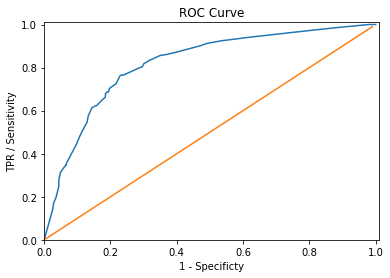

AUC train = 0.8182915556381813


In [20]:
roc_curve_plot(y_train, y_train_prob, 'train')

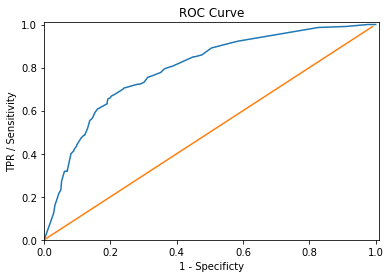

AUC test = 0.7930676855895197


In [21]:
roc_curve_plot(y_test, y_test_prob, 'test')

In [22]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Comparo contra un clasificador Dummy

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)
y_dummy_predictions = dummy_majority.predict(X_test_scaled)
dummy_majority.score(X_test_scaled, y_test)

0.6755162241887905

In [23]:
#basandome en la curva roc elijo punto de corte
y_test_pred = label_observation(y_test_prob, 0.3, 'binary')
confusion_matrix = confusion_matrix(np.array(y_test), y_test_pred)
print(confusion_matrix)

[[417  41]
 [128  92]]


In [24]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_test_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_test_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Accuracy: 0.75
Precision: 0.69
Recall: 0.42
F1: 0.52


In [25]:
print(classification_report(y_test, y_test_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       458
           1       0.69      0.42      0.52       220

    accuracy                           0.75       678
   macro avg       0.73      0.66      0.68       678
weighted avg       0.74      0.75      0.73       678



#### Interpretación

In [26]:
coef_dict = {}
for coef, feat in zip(logit_cv.coef_[0,:],X_r1.columns):
    coef_dict[feat] = coef
    
coef_dict
dict(sorted(coef_dict.items(), key=lambda item: item[1]))

{'momedu': -0.2204689422303785,
 'delivery': -0.17400263516777273,
 'inround': 0.0,
 'agegr1': 0.0,
 'aniany': 0.0,
 'anibeeh': 0.0,
 'anicowm': 0.0,
 'anicowt': 0.0,
 'anidonk': 0.0,
 'anidrau': 0.0,
 'anifish': 0.0,
 'anifshr': 0.0,
 'anigoat': 0.0,
 'aniguin': 0.0,
 'anillam': 0.0,
 'animilk': 0.0,
 'aniothr': 0.0,
 'anioxen': 0.0,
 'anipigs': 0.0,
 'anipoul': 0.0,
 'anirabb': 0.0,
 'anirumi': 0.0,
 'anishee': 0.0,
 'anishri': 0.0,
 'anisnai': 0.0,
 'anispec': 0.0,
 'bcg': 0.0,
 'beca_yl': 0.0,
 'birth': 0.0,
 'birth_age': 0.0,
 'bonograt': 0.0,
 'bwdoc': 0.0,
 'bwght': 0.0,
 'careage': 0.0,
 'carecantread': 0.0,
 'caredu': 0.0,
 'careladder': 0.0,
 'caresex': 0.0,
 'chalcohol': 0.0,
 'chdisability': 0.0,
 'chhealth': 0.0,
 'chhprob': 0.0,
 'childloc': 0.0,
 'chillness': 0.0,
 'chinjury': 0.0,
 'chsmoke': 0.0,
 'chsex': 0.0,
 'cladder': 0.0,
 'commsch': 0.0,
 'commwork': 0.0,
 'credit': 0.0,
 'chrephealth3': 0.0,
 'chrephealth2': 0.0,
 'chrephealth1': 0.0,
 'careldr4yrs': 0.0,
 'dad